# Sentimental analysis of 21 July 2021 tweets to predict the return of Bitcoin

In [161]:
#Libraries for the 
import os
import tweepy as tw
import pandas as pd
from matplotlib import pyplot as plt #(matplotblib)
import seaborn as sns #(visualsize)

In [ ]:
# $ pip install -U textblob
# $ python -m textblob.download_corpora

In [162]:
#Twitter Developer Account Access Keys
consumer_key= 'ATqgLB70FlSN0n1jKiLb1Pqe2'
consumer_secret= 'hnR3v9Ha2O85KhfpYnlmHSkNdVzLfSpPHllL9Y0J3c6OKxrXWV'
access_token= '1890225936-FvuNZEzbIit0WGgSJz16dGFRBdAPFWJ4hSYREuk'
access_token_secret= 'EKEMlUajJBxCCe3qBdOZcE6DDQ6vnS3LdCyo2uPY9HeY6'

In [163]:
# Connection with Twiiter Developer Accont to extract the Twitters
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [164]:
# To extract tweets, count 20000 tweets to be extracted with 4 features.

search_words = "#Bitcoin" 
new_search = search_words + " -filter:retweets"
date_since = "2021-07-16"
tweets = tw.Cursor(api.search, 
                   q=new_search,
                           lang="en",
                           since=date_since).items(500)

users_locs = [[tweet.user.screen_name, tweet.user.location,tweet.text,tweet.created_at.date()] for tweet in tweets]

data = pd.DataFrame(data=users_locs, 
                    columns=['user', "location","text","date"])


len(data)


500

In [165]:
data

,user,location,text,date
0,chesspawnone,🌍,@1MarkMoss @IMFNews Someone will figure it out...,2021-09-07
1,LightningPayBil,Global,https://t.co/0FjvSiwONC #Crypto Flash Crash Wi...,2021-09-07
2,vanreanalyst,Moon,With sadness I must report that #Bitcoin is de...,2021-09-07
3,JasonLi76997663,,#Bitcoin #ElSalvador\n\n$30 purchased in solid...,2021-09-07
4,MaiyroOfficial,"London, England",Business Updates: Return-to-Office Plans Are D...,2021-09-07
...,...,...,...,...
495,coindata_uk,www,"The price of #Bitcoin is currently $47,445.14\...",2021-09-07
496,btcdominance,Blockchain,Current BTC Dominance: 41.87% #Bitcoin #Altcoi...,2021-09-07
497,borad1969,Salem,@rocketdoge_info @GoodProject #RocketDoge_Info...,2021-09-07
498,JulioMedina,127.0.0.1,If you invested your $600.00 stimulus check on...,2021-09-07


In [166]:
#Preprocessing of text tweets to remove : Punction, Numbers, stropwords hash tages , links stemming, lematization
# ref: https://stackoverflow.com/questions/54396405/how-can-i-preprocess-nlp-text-lowercase-remove-special-characters-remove-numb


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
#     print("changed to lower case",sentence)
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english') and "amp"]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)



data['cleanText']=data['text'].map(lambda s:preprocess(s)) 

In [167]:
data

,user,location,text,date,cleanText
0,chesspawnone,🌍,@1MarkMoss @IMFNews Someone will figure it out...,2021-09-07,markmoss imfnews someone figure share humans c...
1,LightningPayBil,Global,https://t.co/0FjvSiwONC #Crypto Flash Crash Wi...,2021-09-07,crypto flash crash wipes billion market value ...
2,vanreanalyst,Moon,With sadness I must report that #Bitcoin is de...,2021-09-07,sadness must report bitcoin dead crashed level...
3,JasonLi76997663,,#Bitcoin #ElSalvador\n\n$30 purchased in solid...,2021-09-07,bitcoin elsalvador purchased solidarity histor...
4,MaiyroOfficial,"London, England",Business Updates: Return-to-Office Plans Are D...,2021-09-07,business updates return office plans disrupted...
...,...,...,...,...,...
495,coindata_uk,www,"The price of #Bitcoin is currently $47,445.14\...",2021-09-07,price bitcoin currently crypto btc btc
496,btcdominance,Blockchain,Current BTC Dominance: 41.87% #Bitcoin #Altcoi...,2021-09-07,current btc dominance bitcoin altcoin cryptocu...
497,borad1969,Salem,@rocketdoge_info @GoodProject #RocketDoge_Info...,2021-09-07,rocketdoge_info goodproject rocketdoge_info de...
498,JulioMedina,127.0.0.1,If you invested your $600.00 stimulus check on...,2021-09-07,invested stimulus check bitcoin investment worth


In [168]:
# textblob library to extract the polarity score to find sentiments

import nltk
from textblob import  TextBlob
data['TextBlob Score']=""
data['TextBlob Sentiment']=""
#df2 = pd.DataFrame(columns=['text', 'sentiment', 'score'])
data['cleanText']=data['cleanText'].astype(str)
for i in range(len(data)):
    sentiment = TextBlob(data['cleanText'][i])
    a=sentiment.sentiment.polarity
    #df2.loc[i] = [data['cleanText'][i]]+[str(0)]+ [a]
    data["TextBlob Score"][i]=a

for i in range(len(data)):
    if(data['TextBlob Score'][i]>0):
        data['TextBlob Sentiment'][i]="Positive"
    elif(data['TextBlob Score'][i]==0):
        data['TextBlob Sentiment'][i]="Neutral"
    else:
        data['TextBlob Sentiment'][i]="Negative"

In [169]:
data

,user,location,text,date,cleanText,TextBlob Score,TextBlob Sentiment
0,chesspawnone,🌍,@1MarkMoss @IMFNews Someone will figure it out...,2021-09-07,markmoss imfnews someone figure share humans c...,0,Neutral
1,LightningPayBil,Global,https://t.co/0FjvSiwONC #Crypto Flash Crash Wi...,2021-09-07,crypto flash crash wipes billion market value ...,0,Neutral
2,vanreanalyst,Moon,With sadness I must report that #Bitcoin is de...,2021-09-07,sadness must report bitcoin dead crashed level...,-0.1,Negative
3,JasonLi76997663,,#Bitcoin #ElSalvador\n\n$30 purchased in solid...,2021-09-07,bitcoin elsalvador purchased solidarity histor...,0,Neutral
4,MaiyroOfficial,"London, England",Business Updates: Return-to-Office Plans Are D...,2021-09-07,business updates return office plans disrupted...,0,Neutral
...,...,...,...,...,...,...,...
495,coindata_uk,www,"The price of #Bitcoin is currently $47,445.14\...",2021-09-07,price bitcoin currently crypto btc btc,0,Neutral
496,btcdominance,Blockchain,Current BTC Dominance: 41.87% #Bitcoin #Altcoi...,2021-09-07,current btc dominance bitcoin altcoin cryptocu...,0,Neutral
497,borad1969,Salem,@rocketdoge_info @GoodProject #RocketDoge_Info...,2021-09-07,rocketdoge_info goodproject rocketdoge_info de...,0,Neutral
498,JulioMedina,127.0.0.1,If you invested your $600.00 stimulus check on...,2021-09-07,invested stimulus check bitcoin investment worth,0.3,Positive


In [170]:
# import SentimentIntensityAnalyzer class 
# from vaderSentiment.vaderSentiment module. 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
data["Vader Score"]=0
data["Vader Sentiment"]=0
sid_obj = SentimentIntensityAnalyzer() 
# function to print sentiments 
# of the sentence. 
for i in range(len(data)):

    # Create a SentimentIntensityAnalyzer object. 
    

    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(data["cleanText"][i])  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        data["Vader Score"][i]= str(sentiment_dict['compound'])
        data["Vader Sentiment"][i]= "Positive"
        

    elif sentiment_dict['compound'] <= - 0.05 : 
        data["Vader Score"][i]= str(sentiment_dict['compound']) 
        data["Vader Sentiment"][i]= "Negative"

    else : 
        data["Vader Score"][i]= str(sentiment_dict['compound'])
        data["Vader Sentiment"][i]= "Neutral"





<ipython-input-170-4da598be5627>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Vader Score"][i]= str(sentiment_dict['compound'])
C:\Users\hp\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-170-4da598be5627>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Vader Sentiment"][i]= "Negative"


In [171]:
data

,user,location,text,date,cleanText,TextBlob Score,TextBlob Sentiment,Vader Score,Vader Sentiment
0,chesspawnone,🌍,@1MarkMoss @IMFNews Someone will figure it out...,2021-09-07,markmoss imfnews someone figure share humans c...,0,Neutral,-0.4404,Negative
1,LightningPayBil,Global,https://t.co/0FjvSiwONC #Crypto Flash Crash Wi...,2021-09-07,crypto flash crash wipes billion market value ...,0,Neutral,-0.0772,Negative
2,vanreanalyst,Moon,With sadness I must report that #Bitcoin is de...,2021-09-07,sadness must report bitcoin dead crashed level...,-0.1,Negative,-0.802,Negative
3,JasonLi76997663,,#Bitcoin #ElSalvador\n\n$30 purchased in solid...,2021-09-07,bitcoin elsalvador purchased solidarity histor...,0,Neutral,0.296,Positive
4,MaiyroOfficial,"London, England",Business Updates: Return-to-Office Plans Are D...,2021-09-07,business updates return office plans disrupted...,0,Neutral,0.0,Neutral
...,...,...,...,...,...,...,...,...,...
495,coindata_uk,www,"The price of #Bitcoin is currently $47,445.14\...",2021-09-07,price bitcoin currently crypto btc btc,0,Neutral,0.0,Neutral
496,btcdominance,Blockchain,Current BTC Dominance: 41.87% #Bitcoin #Altcoi...,2021-09-07,current btc dominance bitcoin altcoin cryptocu...,0,Neutral,0.2023,Positive
497,borad1969,Salem,@rocketdoge_info @GoodProject #RocketDoge_Info...,2021-09-07,rocketdoge_info goodproject rocketdoge_info de...,0,Neutral,0.0,Neutral
498,JulioMedina,127.0.0.1,If you invested your $600.00 stimulus check on...,2021-09-07,invested stimulus check bitcoin investment worth,0.3,Positive,0.2263,Positive


In [172]:
from collections import Counter
Counter(data["TextBlob Sentiment"])

Counter({'Neutral': 237, 'Negative': 61, 'Positive': 202})

In [173]:
from collections import Counter
Counter(data["Vader Sentiment"])

Counter({'Negative': 85, 'Positive': 243, 'Neutral': 172})

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


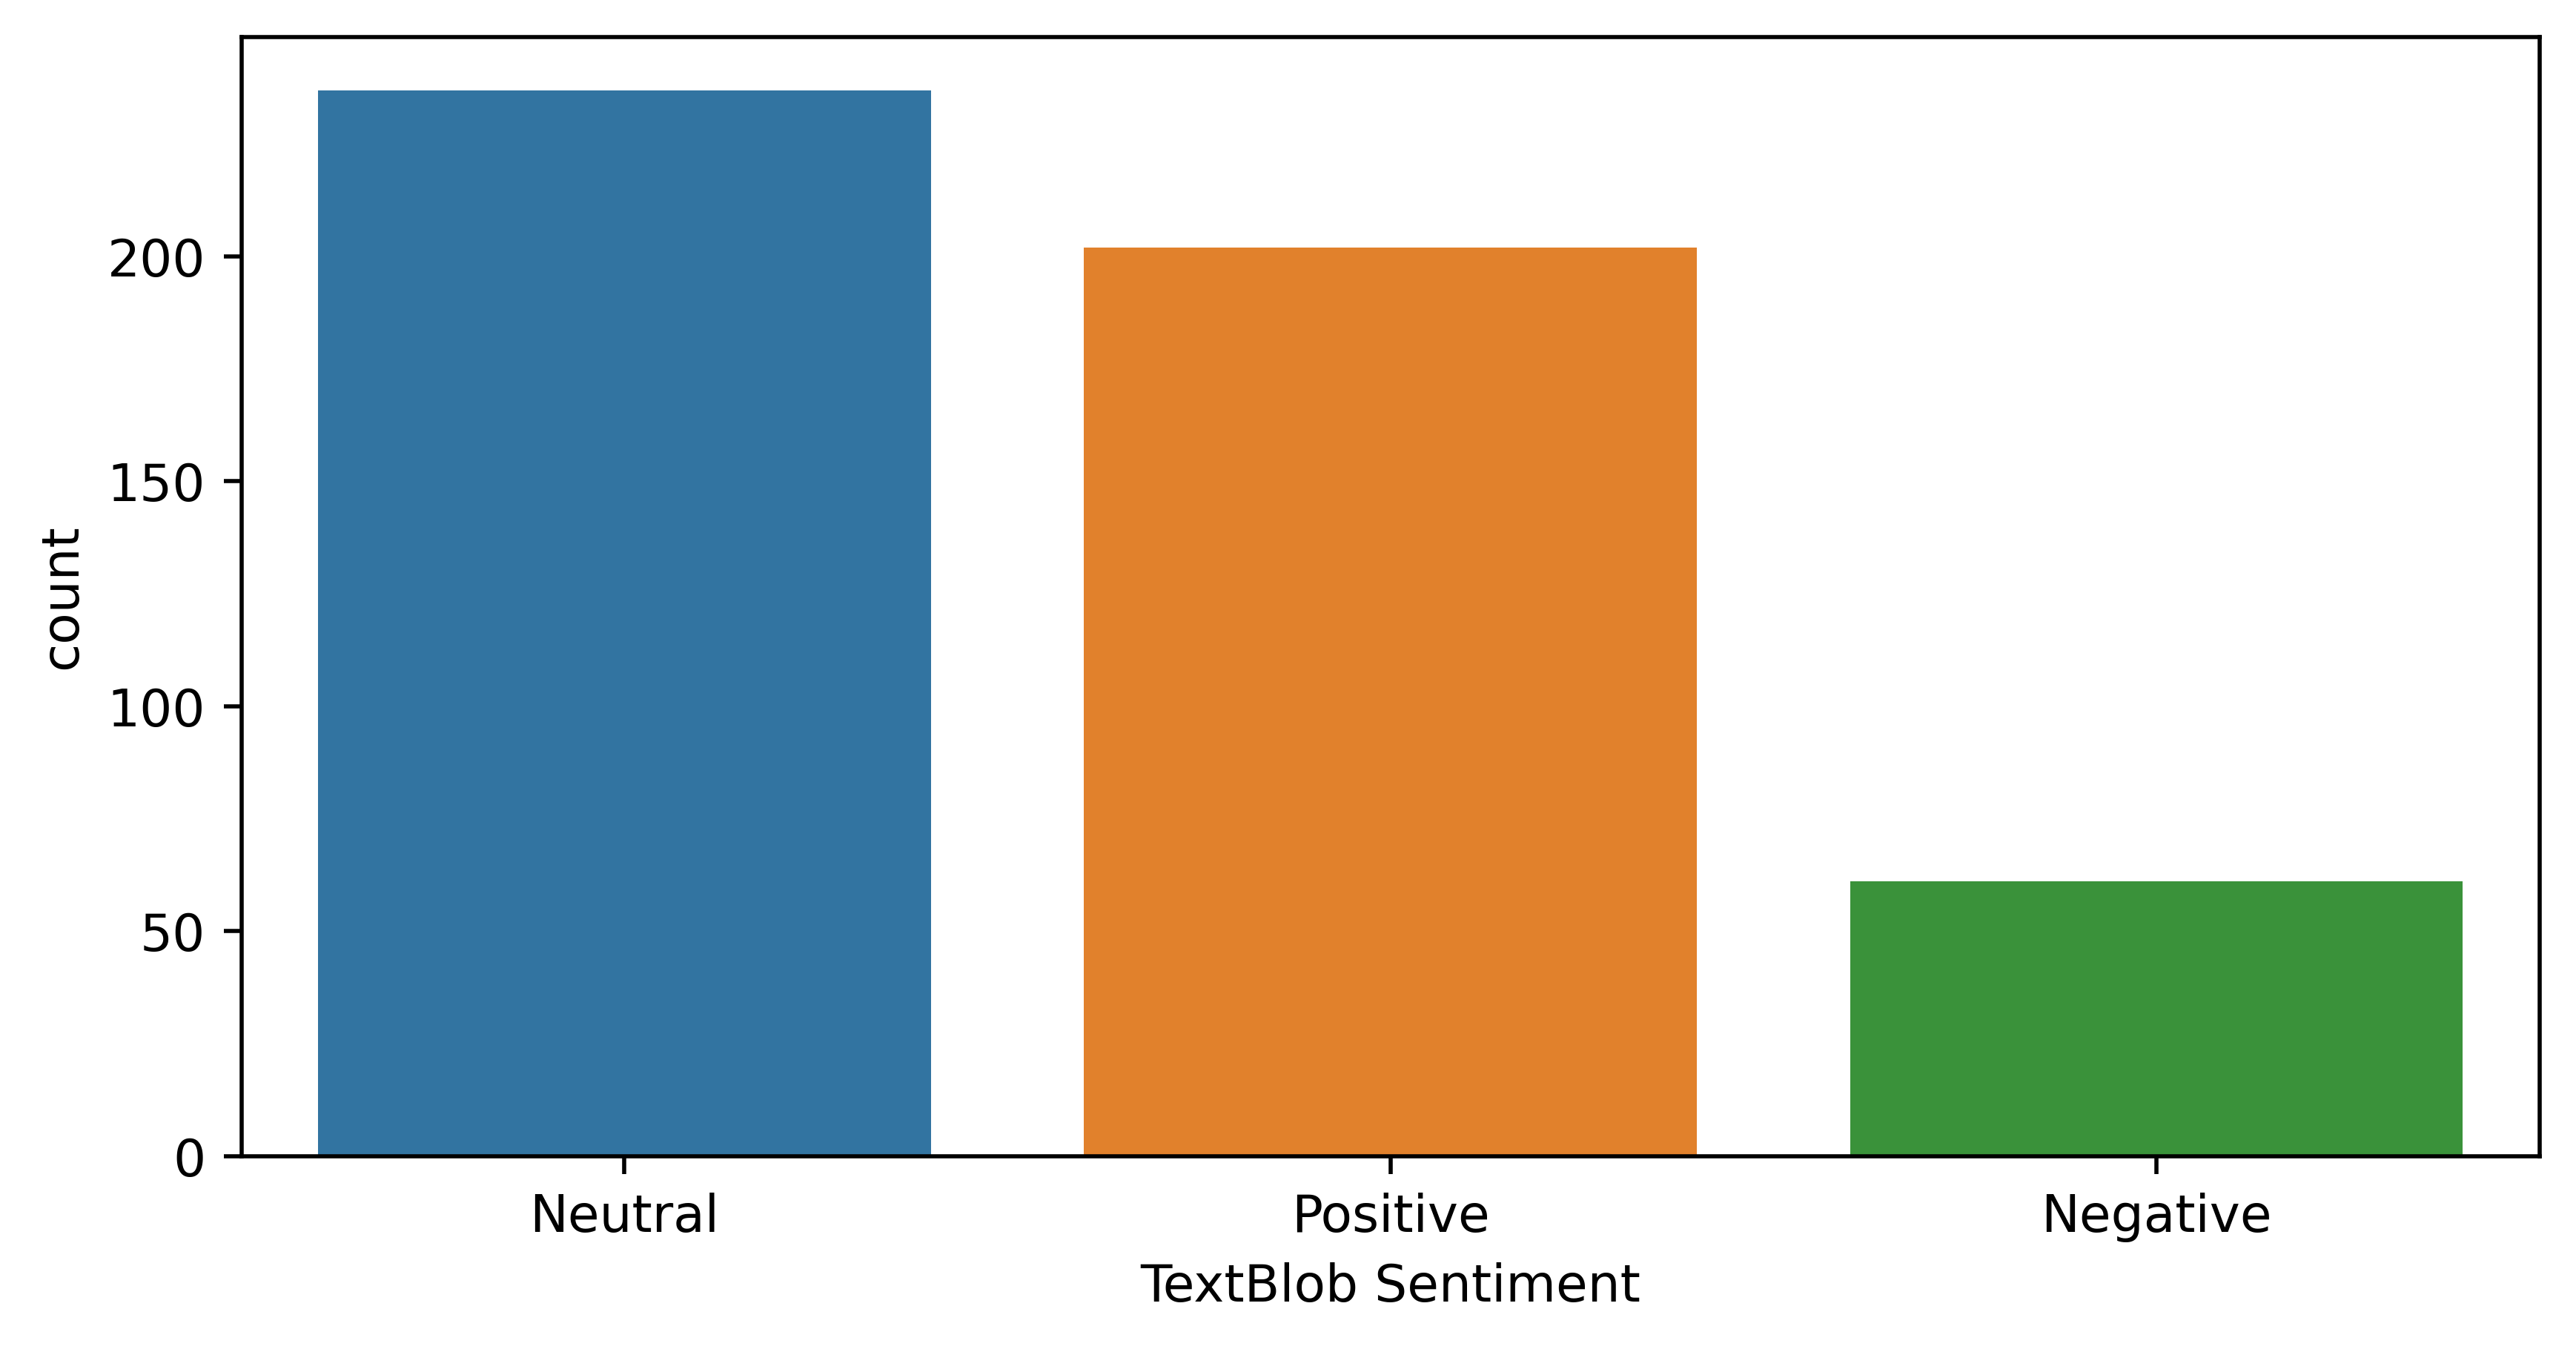

In [174]:
from matplotlib import pyplot
y = data["TextBlob Sentiment"]         
fig, ax = pyplot.subplots(figsize=(8,4),dpi=500)
ax = sns.countplot(y,label="Count",ax=ax,order=data["TextBlob Sentiment"].value_counts().iloc[:15].index )   
plt.savefig('fig3.png')

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


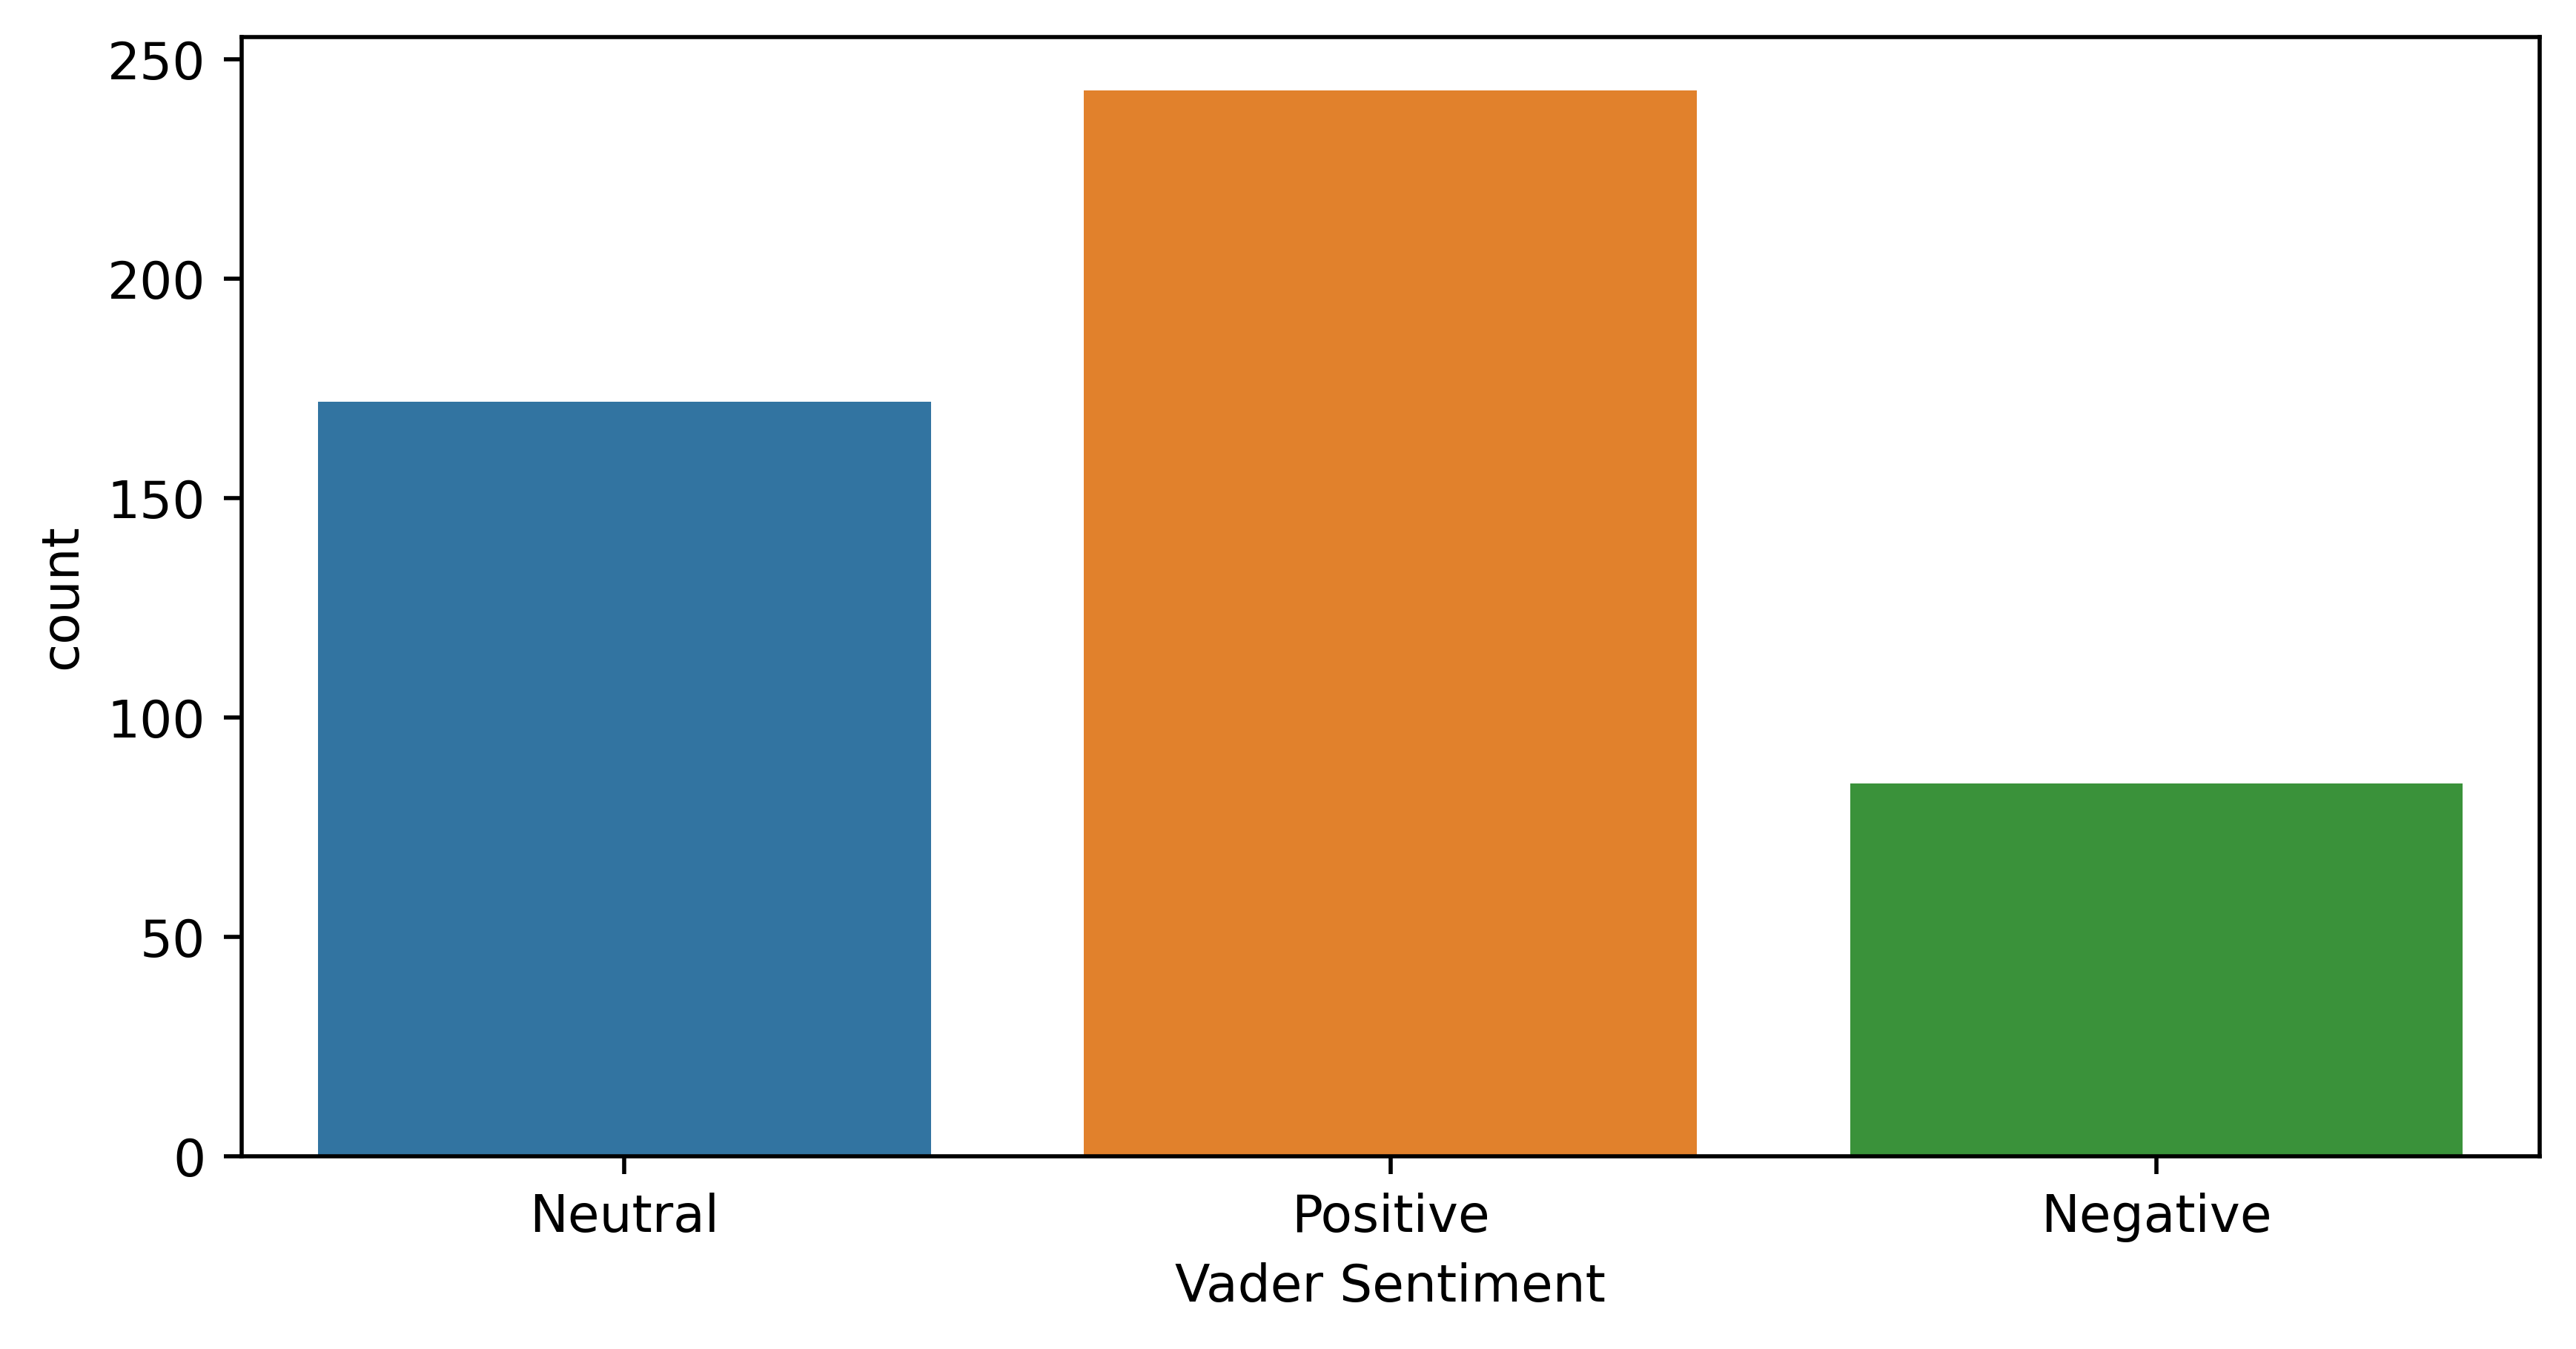

In [175]:
from matplotlib import pyplot
y = data["Vader Sentiment"]         
fig, ax = pyplot.subplots(figsize=(8,4),dpi=500)
ax = sns.countplot(y,label="Count",ax=ax,order=data["TextBlob Sentiment"].value_counts().iloc[:15].index )   
plt.savefig('fig3.png')

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3244 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3223 missing from current font.
  font.set_text(s, 0.0, flags=fla

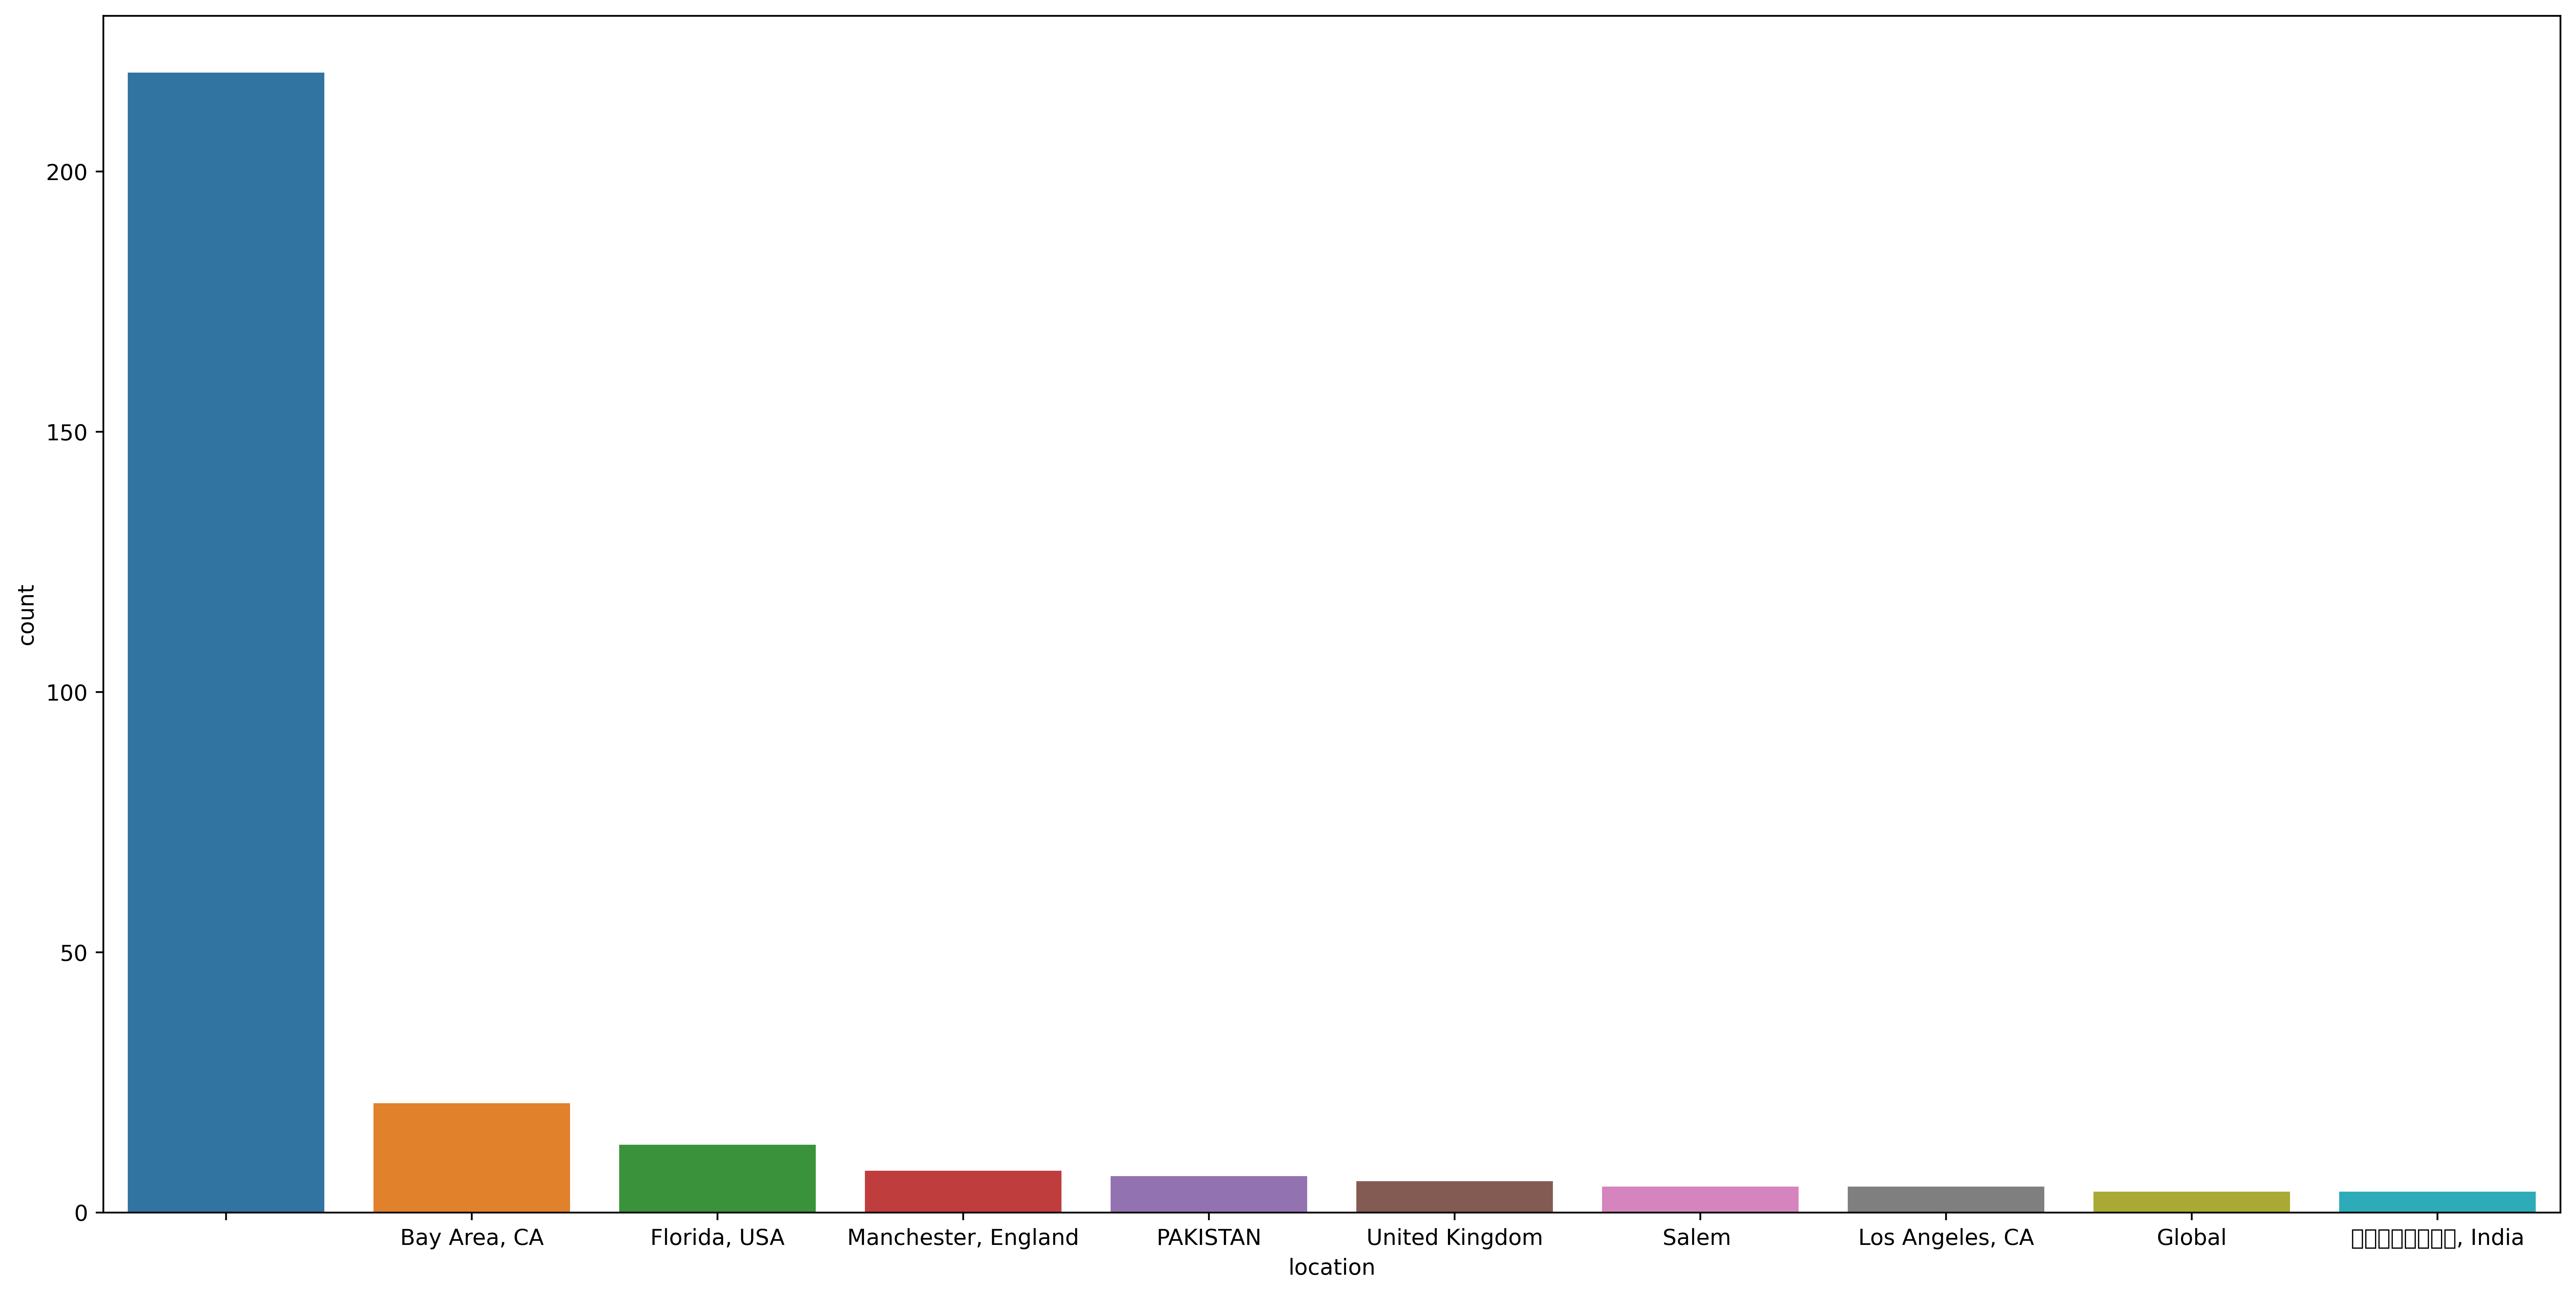

In [176]:
from matplotlib import pyplot
y = data["location"]         
fig, ax = pyplot.subplots(figsize=(20,10),dpi=500)
ax = sns.countplot(y,label="Count",ax=ax,order=data["location"].value_counts().iloc[:10].index )   
plt.savefig('fig3.png')

In [177]:
# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["cleanText"].astype(str), data["TextBlob Sentiment"], test_size=0.15, shuffle=True)

In [178]:
X_train

48             red numbers mean mason bitcoin crypto eth
242                   bitcoin dip etoro rock solid bravo
473    cryptocurrecy crypto market right cryptocurren...
362    come bitfinex highway robbery btc bitcoin eth ...
357    ever heard defichain dfi first crypto project ...
                             ...                        
168    sell coinbase stock bitcoin ethereum cardano b...
20     nayibbukele want visa citizenship salvador alr...
224    lot cryptos massive dip hours ago many gains l...
222    prestonpysh best time buy bitcoin everyone els...
91                               good move start bitcoin
Name: cleanText, Length: 425, dtype: object

In [179]:
from sklearn.feature_extraction.text import CountVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = CountVectorizer()
# 3. fit
# 4. transform training data
X_train_dtf = vect.fit_transform(X_train)
X_test_dtf = vect.transform(X_test)

In [180]:
print(len(vect.get_feature_names()))

1498


In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

In [182]:
print(len(vectorizer.get_feature_names()))

1498


In [183]:
print(X_train_tf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [184]:
print(X_test_tf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [185]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# BoW Features

In [186]:
from sklearn.svm import SVC
print("SVC")
svm = SVC(kernel='linear', C=1.0, random_state=500)
svm.fit(X_train_dtf,y_train)
y_pred=svm.predict(X_test_dtf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

SVC
0.6666666666666666
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
     Neutral       0.69      0.79      0.74        43
    Positive       0.76      0.59      0.67        27

    accuracy                           0.67        75
   macro avg       0.49      0.46      0.47        75
weighted avg       0.67      0.67      0.66        75

[[ 0  4  1]
 [ 5 34  4]
 [ 0 11 16]]


In [187]:
from sklearn.linear_model import LogisticRegression
# 2. instantiate a logistic regression model
print("LR")
logreg = LogisticRegression(solver='saga',random_state=1000,multi_class='multinomial',C=3.0)
logreg.fit(X_train_dtf,y_train)
y_pred=logreg.predict(X_test_dtf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

LR
0.6933333333333334
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
     Neutral       0.75      0.77      0.76        43
    Positive       0.66      0.70      0.68        27

    accuracy                           0.69        75
   macro avg       0.47      0.49      0.48        75
weighted avg       0.67      0.69      0.68        75

[[ 0  4  1]
 [ 1 33  9]
 [ 1  7 19]]


C:\Users\hp\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [188]:
from sklearn.naive_bayes import GaussianNB
# 2. instantiate a GaussianNB model
print("GNB")
gnb = GaussianNB()
gnb.fit(X_train_dtf.toarray(),y_train)
y_pred=gnb.predict(X_test_dtf.toarray())
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

GNB
0.6133333333333333
              precision    recall  f1-score   support

    Negative       0.07      0.20      0.11         5
     Neutral       0.79      0.60      0.68        43
    Positive       0.68      0.70      0.69        27

    accuracy                           0.61        75
   macro avg       0.51      0.50      0.49        75
weighted avg       0.70      0.61      0.65        75

[[ 1  2  2]
 [10 26  7]
 [ 3  5 19]]


In [189]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=300, random_state=5, max_depth=300)
print("ExtraTreesClassifier")
etc.fit(X_train_dtf.toarray(),y_train)
y_pred=etc.predict(X_test_dtf.toarray())
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

ExtraTreesClassifier
0.7866666666666666
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
     Neutral       0.76      0.91      0.83        43
    Positive       0.91      0.74      0.82        27

    accuracy                           0.79        75
   macro avg       0.56      0.55      0.55        75
weighted avg       0.77      0.79      0.77        75

[[ 0  5  0]
 [ 2 39  2]
 [ 0  7 20]]


# TF-IDF Features

In [190]:
from sklearn.svm import SVC
print("SVC")
svm = SVC(kernel='linear', C=1.0, random_state=500)
svm.fit(X_train_tf,y_train)
y_pred=svm.predict(X_test_tf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

SVC
0.7333333333333333
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
     Neutral       0.76      0.81      0.79        43
    Positive       0.69      0.74      0.71        27

    accuracy                           0.73        75
   macro avg       0.48      0.52      0.50        75
weighted avg       0.68      0.73      0.71        75

[[ 0  4  1]
 [ 0 35  8]
 [ 0  7 20]]


C:\Users\hp\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.linear_model import LogisticRegression
# LogisticRegression
print("LR")
logreg = LogisticRegression(solver='saga',random_state=1000,multi_class='multinomial',C=3.0)
logreg.fit(X_train_tf,y_train)
y_pred=logreg.predict(X_test_tf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn.naive_bayes import GaussianNB
#GaussianNB
print("GNB")
gnb = GaussianNB()
gnb.fit(X_train_tf.toarray(),y_train)
y_pred=gnb.predict(X_test_tf.toarray())
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=300, random_state=5, max_depth=300)
print("ExtraTreesClassifier")
etc.fit(X_train_tf.toarray(),y_train)
y_pred=etc.predict(X_test_tf.toarray())
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

# Bitcoin price prediction using machine learning models

In [215]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator

In [216]:
df=pd.read_csv("BTC_USD Bitfinex Historical Data.csv",index_col='Date', parse_dates=True,infer_datetime_format= True)
df=df.iloc[::-1]

In [217]:
df[:3]

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2012-02-02,6.1,6.1,6.1,6.1,-,0.00%
2012-02-03,6.0,6.0,6.0,6.0,-,-2.30%
2012-02-04,5.9,5.9,5.9,5.9,-,-1.51%


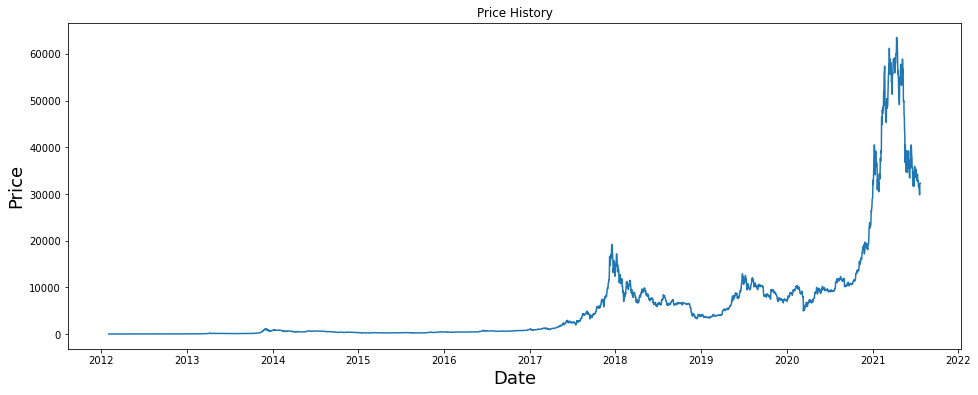

In [218]:
plt.figure(figsize=(16,6))
plt.title('Price History')
plt.plot(df['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [219]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Price'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len


3284

In [220]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[2.99147587e-05],
       [2.83402977e-05],
       [2.67658367e-05],
       ...,
       [5.05981377e-01],
       [5.08799662e-01],
       [5.08270644e-01]])

In [221]:
len(scaled_data)

3456

# LSTM Model

In [222]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([2.99147587e-05, 2.83402977e-05, 2.67658367e-05, 2.36169147e-05,
       1.88935318e-05, 2.36169147e-05, 2.20424538e-05, 2.51913757e-05,
       2.67658367e-05, 2.20424538e-05, 2.04679928e-05, 1.73190708e-05,
       4.72338295e-06, 1.57446098e-06, 1.57446098e-06, 3.14892197e-06,
       0.00000000e+00, 3.14892197e-06, 3.14892197e-06, 1.57446098e-06,
       3.14892197e-06, 1.25956879e-05, 1.25956879e-05, 9.44676590e-06,
       1.10212269e-05, 1.25956879e-05, 1.10212269e-05, 1.10212269e-05,
       1.10212269e-05, 7.87230492e-06, 6.29784393e-06, 9.44676590e-06,
       1.25956879e-05, 1.25956879e-05, 1.10212269e-05, 1.10212269e-05,
       1.10212269e-05, 9.44676590e-06, 1.10212269e-05, 1.10212269e-05,
       1.73190708e-05, 1.88935318e-05, 1.73190708e-05, 1.73190708e-05,
       1.57446098e-05, 1.73190708e-05, 7.87230492e-06, 9.44676590e-06,
       9.44676590e-06, 7.87230492e-06, 7.87230492e-06, 7.87230492e-06,
       6.29784393e-06, 6.29784393e-06, 9.44676590e-06, 9.44676590e-06,
     

In [223]:
for i in range(60, len(train_data)):
    print(i,train_data[i, 0])
        

60 1.2595687866258986e-05
61 1.1021226882976628e-05
62 1.1021226882976628e-05
63 1.1021226882976628e-05
64 1.1021226882976628e-05
65 7.872304916411871e-06
66 9.446765899694243e-06
67 1.1021226882976628e-05
68 9.446765899694243e-06
69 1.1021226882976628e-05
70 1.1021226882976628e-05
71 1.1021226882976628e-05
72 1.2595687866258986e-05
73 1.2595687866258986e-05
74 1.1021226882976628e-05
75 1.2595687866258986e-05
76 1.4170148849541357e-05
77 1.4170148849541357e-05
78 1.73190708161061e-05
79 1.73190708161061e-05
80 1.5744609832823742e-05
81 1.2595687866258986e-05
82 1.4170148849541357e-05
83 1.4170148849541357e-05
84 1.4170148849541357e-05
85 1.4170148849541357e-05
86 1.2595687866258986e-05
87 1.1021226882976628e-05
88 1.1021226882976628e-05
89 1.2595687866258986e-05
90 1.4170148849541357e-05
91 1.4170148849541357e-05
92 1.4170148849541357e-05
93 1.4170148849541357e-05
94 1.4170148849541357e-05
95 1.4170148849541357e-05
96 1.4170148849541357e-05
97 1.2595687866258986e-05
98 9.44676589969424

832 0.006897713567760077
833 0.0068929901848102295
834 0.0068426074333451945
835 0.006845756355311759
836 0.007428306919126237
837 0.007453498294858755
838 0.007842390157729503
839 0.007955751348525832
840 0.007842390157729503
841 0.008848470726046938
842 0.008987023292575787
843 0.008908300243411668
844 0.009018512512241434
845 0.008955534072910139
846 0.009837232223548268
847 0.009941146648444905
848 0.010112762895622684
849 0.01047488892177763
850 0.010685866693537468
851 0.01020408163265306
852 0.010377272340814122
853 0.010246592079201686
854 0.010372548957864276
855 0.010361527730981299
856 0.010226124086419016
857 0.010224549625435732
858 0.00996476356319414
859 0.009223192440068143
860 0.009106682327305249
861 0.008662684330019618
862 0.008924044853244491
863 0.009065746341739905
864 0.009605786459005759
865 0.009561701551473853
866 0.009412127758062027
867 0.009396383148229204
868 0.009405829914128899
869 0.009503446495092405
870 0.009369617311513404
871 0.009180681993519518
8

1421 0.0065843958320868845
1422 0.006549757690454672
1423 0.0067339696254987095
1424 0.006620608434702379
1425 0.0066883102569835215
1426 0.00676703330614764
1427 0.006746565313364969
1428 0.006683586874033674
1429 0.006749714235331533
1430 0.006732395164515428
1431 0.006672565647150698
1432 0.007160648551968234
1433 0.0070819255028041145
1434 0.007006351375606561
1435 0.007009500297573125
1436 0.007007925836589843
1437 0.006735544086481992
1438 0.006721373937632452
1439 0.006693033639933369
1440 0.005584613107702577
1441 0.006049079097770877
1442 0.005949888055824089
1443 0.006027036644004924
1444 0.005901079765342335
1445 0.006537162002588413
1446 0.0064049072799926944
1447 0.005932568985007982
1448 0.006004994190238972
1449 0.0062758014793635394
1450 0.00609001508333622
1451 0.006094738466286067
1452 0.006152993522667514
1453 0.00589163299944264
1454 0.005879037311576382
1455 0.005869590545676687
1456 0.005688527532599214
1457 0.005781420730612874
1458 0.00580503764536211
1459 0.005

2148 0.21210823474583476
2149 0.21442269239125986
2150 0.24679361020754545
2151 0.2419915042085342
2152 0.22531796239557386
2153 0.22534945161523953
2154 0.19480490853956148
2155 0.21720948833166964
2156 0.21018739234623027
2157 0.23153393435757266
2158 0.2385434346551458
2159 0.23862215770430992
2160 0.26628543718058123
2161 0.2701271219797902
2162 0.2549335734911153
2163 0.23500089744276045
2164 0.22701838025751883
2165 0.23446558070844445
2166 0.20880186668094178
2167 0.21694182996451164
2168 0.22336563077630373
2169 0.2133992927521263
2170 0.2136669511192843
2171 0.17425819270772652
2172 0.17441563880605473
2173 0.17383308824224028
2174 0.1806190150801873
2175 0.2003312665908826
2176 0.18121731025383458
2177 0.16951906514804657
2178 0.1702748064200221
2179 0.1796428492705522
2180 0.17542329383535546
2181 0.17422670348806085
2182 0.18038284593269494
2183 0.1863343084495023
2184 0.17646243808432183
2185 0.16013527768768362
2186 0.1618514401594614
2187 0.14448670997484012
2188 0.13999

2831 0.14491023997934308
2832 0.1382093340344933
2833 0.13892728824287007
2834 0.14271229244668088
2835 0.13750554997496608
2836 0.1389587774625357
2837 0.1385037582383671
2838 0.13621449196867455
2839 0.133696928856406
2840 0.13413305454877522
2841 0.13435033016446818
2842 0.12934669315959682
2843 0.12848703746272463
2844 0.12788086998416093
2845 0.12071234912727627
2846 0.11523165044447033
2847 0.11569769089552191
2848 0.10959980350726928
2849 0.11279123592038265
2850 0.1132682975983172
2851 0.11879465564963834
2852 0.11740125767943344
2853 0.12268829766129564
2854 0.11959133290717922
2855 0.11723279035422222
2856 0.11566147829290642
2857 0.11543633037229703
2858 0.11389650753064687
2859 0.1170737697949107
2860 0.11940869543311847
2861 0.1186986135296581
2862 0.11903554818008054
2863 0.11612122090002487
2864 0.11415471913190518
2865 0.11377842295690069
2866 0.11367293407102078
2867 0.11460501497312393
2868 0.1117331981396169
2869 0.11255034338994044
2870 0.10899363602870557
2871 0.10

In [224]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
pred=model.fit(x_train, y_train, batch_size=1, epochs=1)

3224/3224 [==============================] - 103s 30ms/step - loss: 8.1450e-04


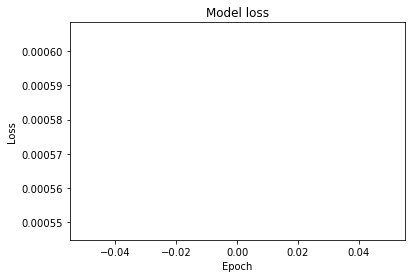

In [225]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(pred.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [226]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2962.3039230165787

<ipython-input-233-e12b79233285>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


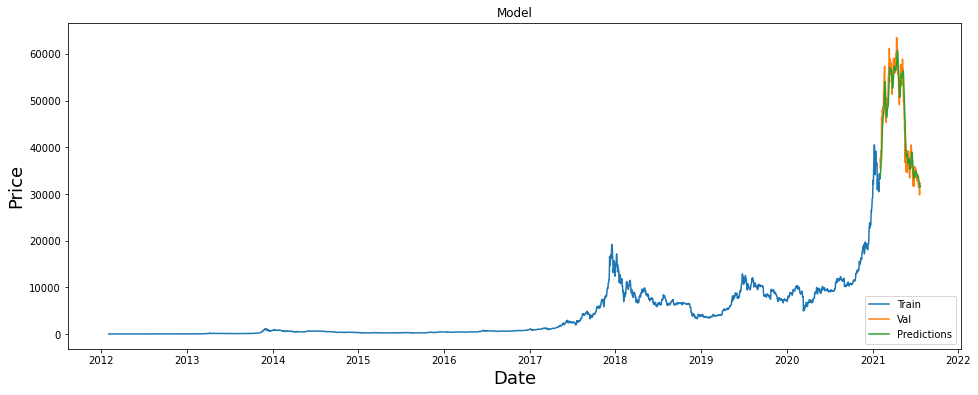

In [233]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [12]:
valid

,Price,Predictions
Date,,
2021-02-02,35563.0,34040.136719
2021-02-03,37677.0,36532.390625
2021-02-04,36975.0,38703.597656
2021-02-05,38260.0,37339.585938
2021-02-06,39257.0,38687.562500
...,...,...
2021-07-19,30847.0,32616.173828
2021-07-20,29806.1,31416.296875
2021-07-21,32141.0,30269.835938


In [13]:

print('MAE:', mean_absolute_error(valid["Price"],valid["Predictions"]))
print('MSE:',mean_squared_error(valid["Price"],valid["Predictions"]))
print('RMSE:',math.sqrt(mean_squared_error(valid["Price"],valid["Predictions"])))
from sklearn.metrics import r2_score
print('R2:',r2_score(valid["Price"],valid["Predictions"]))

MAE: 1949.0592909702036
MSE: 6179121.669134545
RMSE: 2485.783914409003
R2: 0.9393179125683145


# Linear Regression Model

In [282]:
df= pd.read_csv('BTC_USD Bitfinex Historical Data.csv', parse_dates=['Date'], index_col='Date')

In [283]:
df=df.iloc[::-1]
df.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-07-19,30847.0,31824.0,31924.0,30514.0,12.80K,-3.07%
2021-07-20,29806.1,30847.0,31075.0,29341.0,8.88K,-3.37%
2021-07-21,32141.0,29806.1,32804.0,29545.0,8.25K,7.83%
2021-07-22,32320.0,32141.0,32609.7,31747.0,5.23K,0.56%
2021-07-23,32286.4,32320.0,32931.0,32228.0,5.27K,-0.10%


In [284]:
btc=df

In [285]:

btc['ohlc_average'] = (btc['Open'] + btc['High'] + btc['Low'] + btc['Price']) / 4

In [286]:
btc

,Price,Open,High,Low,Vol.,Change %,ohlc_average
Date,,,,,,,
2012-02-02,6.1,6.1,6.1,6.1,-,0.00%,6.100
2012-02-03,6.0,6.0,6.0,6.0,-,-2.30%,6.000
2012-02-04,5.9,5.9,5.9,5.9,-,-1.51%,5.900
2012-02-05,5.7,5.7,5.7,5.7,-,-3.07%,5.700
2012-02-06,5.4,5.4,5.4,5.4,-,-4.22%,5.400
...,...,...,...,...,...,...,...
2021-07-19,30847.0,31824.0,31924.0,30514.0,12.80K,-3.07%,31277.250
2021-07-20,29806.1,30847.0,31075.0,29341.0,8.88K,-3.37%,30267.275
2021-07-21,32141.0,29806.1,32804.0,29545.0,8.25K,7.83%,31074.025


In [287]:
btc['Price_After_Month']=btc['Price'].shift(-30) #This will be our label
btc.drop(['Vol.','Change %'],axis=1,inplace=True)

In [288]:
btc

,Price,Open,High,Low,ohlc_average,Price_After_Month
Date,,,,,,
2012-02-02,6.1,6.1,6.1,6.1,6.100,4.6
2012-02-03,6.0,6.0,6.0,6.0,6.000,4.8
2012-02-04,5.9,5.9,5.9,5.9,5.900,5.0
2012-02-05,5.7,5.7,5.7,5.7,5.700,5.0
2012-02-06,5.4,5.4,5.4,5.4,5.400,4.9
...,...,...,...,...,...,...
2021-07-19,30847.0,31824.0,31924.0,30514.0,31277.250,NaN
2021-07-20,29806.1,30847.0,31075.0,29341.0,30267.275,NaN
2021-07-21,32141.0,29806.1,32804.0,29545.0,31074.025,NaN


In [263]:
len(btc['Price_After_Month'])

3456

In [267]:
btc['Price_After_Month'].tail(40)

Date
2021-06-14    32822.6
2021-06-15    31857.0
2021-06-16    31429.0
2021-06-17    31559.0
2021-06-18    31824.0
2021-06-19    30847.0
2021-06-20    29806.1
2021-06-21    32141.0
2021-06-22    32320.0
2021-06-23    32286.4
2021-06-24        NaN
2021-06-25        NaN
2021-06-26        NaN
2021-06-27        NaN
2021-06-28        NaN
2021-06-29        NaN
2021-06-30        NaN
2021-07-01        NaN
2021-07-02        NaN
2021-07-03        NaN
2021-07-04        NaN
2021-07-05        NaN
2021-07-06        NaN
2021-07-07        NaN
2021-07-08        NaN
2021-07-09        NaN
2021-07-10        NaN
2021-07-11        NaN
2021-07-12        NaN
2021-07-13        NaN
2021-07-14        NaN
2021-07-15        NaN
2021-07-16        NaN
2021-07-17        NaN
2021-07-18        NaN
2021-07-19        NaN
2021-07-20        NaN
2021-07-21        NaN
2021-07-22        NaN
2021-07-23        NaN
Name: Price_After_Month, dtype: float64

In [289]:
#Preprocessing
from sklearn import preprocessing
btc.dropna(inplace=True)
X=btc.drop('Price_After_Month',axis=1)
X1=preprocessing.scale(X)#We need to scale our values to input them in our model
y=btc['Price_After_Month']


In [296]:
btc

,Price,Open,High,Low,ohlc_average,Price_After_Month
Date,,,,,,
2012-02-02,6.1,6.1,6.1,6.1,6.10,4.6
2012-02-03,6.0,6.0,6.0,6.0,6.00,4.8
2012-02-04,5.9,5.9,5.9,5.9,5.90,5.0
2012-02-05,5.7,5.7,5.7,5.7,5.70,5.0
2012-02-06,5.4,5.4,5.4,5.4,5.40,4.9
...,...,...,...,...,...,...
2021-06-19,35585.8,35802.0,36236.0,35460.0,35770.95,30847.0
2021-06-20,35631.0,35585.8,35966.0,33725.0,35226.95,29806.1
2021-06-21,31761.0,35631.0,35631.0,31475.0,33624.50,32141.0


In [281]:
btc

,Price,Open,High,Low,Price_After_Month
Date,,,,,
2012-02-02,6.1,6.1,6.1,6.1,4.6
2012-02-03,6.0,6.0,6.0,6.0,4.8
2012-02-04,5.9,5.9,5.9,5.9,5.0
2012-02-05,5.7,5.7,5.7,5.7,5.0
2012-02-06,5.4,5.4,5.4,5.4,4.9
...,...,...,...,...,...
2021-06-19,35585.8,35802.0,36236.0,35460.0,30847.0
2021-06-20,35631.0,35585.8,35966.0,33725.0,29806.1
2021-06-21,31761.0,35631.0,35631.0,31475.0,32141.0


In [290]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=101)

In [291]:
y_test.tail()

Date
2020-11-14    19281.0
2017-11-08    15869.0
2014-12-12      266.2
2020-01-30     8557.3
2016-07-03      604.1
Name: Price_After_Month, dtype: float64

In [292]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
#reg=RandomForestRegressor(n_estimators=200,random_state=101)
reg=LinearRegression()
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data

Accuracy is: 92.0507 %


In [293]:
preds = reg.predict(X_test)
print("The prediction is:",preds[1],"But the real value is:" ,y_test[1])
#We can see that our predictions are kind of accurate but we still need to work on on them a l

The prediction is: 6951.484649318551 But the real value is: 14997.0


In [294]:

print('MAE:', mean_absolute_error(preds,y_test))
print('MSE:',mean_squared_error(preds,y_test))
print('RMSE:',math.sqrt(mean_squared_error(preds,y_test)))
from sklearn.metrics import r2_score
print('R2:',r2_score(preds,y_test))

MAE: 1303.244991880326
MSE: 9516202.5505144
RMSE: 3084.834282504394
R2: 0.917715325562393


In [297]:
#Apply our model and get our prediction
X_30=X[-30:]#We'll take the last 30 elements to make our predictions on them
X_30

,Price,Open,High,Low,ohlc_average
Date,,,,,
2021-05-25,38363.0,38772.9,39761.0,36760.5,38414.350
2021-05-26,39301.0,38363.0,40497.8,38020.2,39045.500
2021-05-27,38435.0,39301.0,40120.0,37381.0,38809.250
2021-05-28,35667.0,38484.7,38484.7,35028.0,36916.100
2021-05-29,34570.0,35667.0,36910.5,33681.0,35207.125
2021-05-30,35615.0,34570.0,36138.0,33680.0,35000.750
2021-05-31,37305.0,35615.0,37305.0,34527.0,36188.000
2021-06-01,36672.6,37305.0,37624.8,35928.0,36882.600
2021-06-02,37590.0,36672.6,38053.0,36192.3,37126.975


In [298]:
forecast=reg.predict(X_30)

In [299]:
#creating a new column which contains the predictions!  
from datetime import datetime, timedelta
last_date=btc.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=30,freq='D')
df1=pd.DataFrame(forecast,columns=['Forecast'],index=date)
btc=btc.append(df1)
btc.tail()

,Price,Open,High,Low,ohlc_average,Price_After_Month,Forecast
2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,34854.275549
2021-07-20,NaN,NaN,NaN,NaN,NaN,NaN,35937.313162
2021-07-21,NaN,NaN,NaN,NaN,NaN,NaN,32206.982618
2021-07-22,NaN,NaN,NaN,NaN,NaN,NaN,33498.264842
2021-07-23,NaN,NaN,NaN,NaN,NaN,NaN,33594.392105


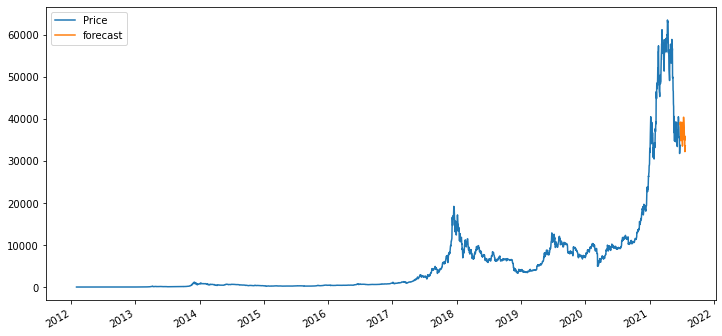

In [246]:
#Now we'll plot our forecast! 
btc['Price'].plot(figsize=(12,6),label='Price')
btc['Forecast'].plot(label='forecast')
plt.legend()

# Random Forest Regressor

Accuracy is: 94.277 %
The prediction is: 7804.130321178695 But the real value is: 14997.0


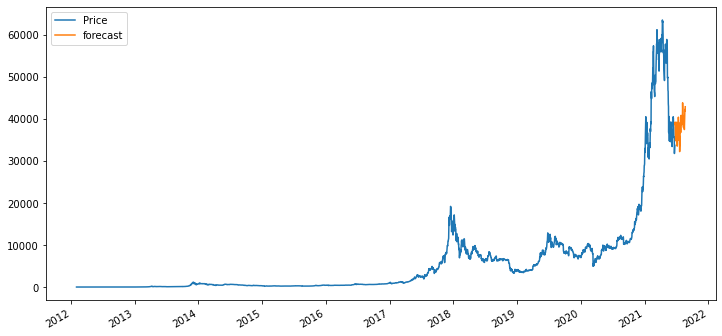

In [300]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=300,max_depth=5)
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data


preds = reg.predict(X_test)
print("The prediction is:",preds[1],"But the real value is:" ,y_test[1])
#We can see that our predictions are kind of accurate but we still need to work on on them a l

#Apply our model and get our prediction
X_30=X[-30:]#We'll take the last 30 elements to make our predictions on them
forecast=reg.predict(X_30)

#creating a new column which contains the predictions! 
#Proceed at your own risk!  
from datetime import datetime, timedelta
last_date=btc.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=30,freq='D')
df1=pd.DataFrame(forecast,columns=['Forecast'],index=date)
btc=btc.append(df1)
btc.tail()


#Now we'll plot our forecast! 
btc['Price'].plot(figsize=(12,6),label='Price')
btc['Forecast'].plot(label='forecast')
plt.legend()

In [301]:
print('MAE:', mean_absolute_error(preds,y_test))
print('MSE:',mean_squared_error(preds,y_test))
print('RMSE:',math.sqrt(mean_squared_error(preds,y_test)))
from sklearn.metrics import r2_score
print('R2:',r2_score(preds,y_test))

MAE: 1094.6856634776236
MSE: 6851018.53696278
RMSE: 2617.4450399125444
R2: 0.9433015784219534


Reference:
1: https://medium.com/atoti/is-it-enough-to-focus-just-on-twitter-sentiment-9e1f65a867c2
2: https://medium.com/atoti/how-im-failing-my-twitter-sentiment-analysis-for-cryptocurrency-prediction-149a1730a6fd
3: https://www.youtube.com/watch?t=939&v=tepxdcepTbY&feature=youtu.be